In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from datetime import date, timedelta
import pickle    
import matplotlib
import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math 

plt.style.use('fivethirtyeight')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

c = mcolors.ColorConverter().to_rgb
positive_cm = ListedColormap([c('#e1e5e5'),c('#e78c79'),c('#d63b36')])
negative_cm = ListedColormap([c('#e1e5e5'), c('#a1ceee'),c('#28aee4')])

from PIL import Image

In [9]:
def nhl_game_ids(start="2021-10-01", end="2022-04-30", game_type="R"):
    url = f"https://statsapi.web.nhl.com/api/v1/schedule?startDate={start}&endDate={end}"
    r = requests.get(url)
    games = r.json()
    game_ids = []
    for d in games["dates"]:
        for g in d["games"]:
            if g["gameType"] == game_type:
                game_ids.append(g["gamePk"])
    return game_ids

def nhl_game_stats(game_id):
    url = "http://statsapi.web.nhl.com/api/v1/game/" + str(game_id) + "/feed/live"
    r = requests.get(url)
    return r.json()

In [10]:
games = nhl_game_ids()

In [11]:
game_data = [nhl_game_stats(game_id=g) for g in games]

In [12]:
year = "2022"
with open(year+'FullDataset.pkl', 'wb') as f:
    pickle.dump(game_data, f, pickle.HIGHEST_PROTOCOL)

In [13]:
year = "2022"
with open(year+'FullDataset.pkl', 'rb') as f:
    game_data = pickle.load(f)

# Need to get both the leauge average efficiencies and compare against players:
anchoring={};anchoring['x'] = [];anchoring['y'] = [];

leauge_data = {};
leauge_data['Shot'] = {};leauge_data['Shot']['x'] = [];leauge_data['Shot']['y'] = [];
leauge_data['Missed Shot'] = {};leauge_data['Missed Shot']['x'] = [];leauge_data['Missed Shot']['y'] = [];
leauge_data['Blocked Shot'] = {};leauge_data['Blocked Shot']['x'] = [];leauge_data['Blocked Shot']['y'] = [];
leauge_data['Goal'] = {};leauge_data['Goal']['x'] = [];leauge_data['Goal']['y'] = [];

event_types = ['Shot','Missed Shot','Blocked Shot','Goal']
for data in game_data:
    if 'liveData' not in data:
        continue
    plays = data['liveData']['plays']['allPlays']
    for play in plays:
        for event in event_types:
            if play['result']['event'] in [event]:
                if 'x' in play['coordinates']:
                    leauge_data[event]['x'].append(play['coordinates']['x'])
                    leauge_data[event]['y'].append(play['coordinates']['y'])

    # Do anchor
    for play in plays:
        if play['result']['event'] in ['Faceoff']:
            if 'x' in play['coordinates']:
                anchoring['x'].append(play['coordinates']['x'])
                anchoring['y'].append(play['coordinates']['y'])

In [15]:
# PLAYERS
# full_name = 'Auston Matthews'
# full_name = 'Sidney Crosby'
# full_name = 'John Tavares'
full_name = 'Alex Ovechkin'
# full_name = 'Nikita Kucherov'
# full_name = 'Nikita Kucherov'

player_data = {};
player_data['Shot'] = {};player_data['Shot']['x'] = [];player_data['Shot']['y'] = [];
player_data['Missed Shot'] = {};player_data['Missed Shot']['x'] = [];player_data['Missed Shot']['y'] = [];
player_data['Blocked Shot'] = {};player_data['Blocked Shot']['x'] = [];player_data['Blocked Shot']['y'] = [];
player_data['Goal'] = {};player_data['Goal']['x'] = [];player_data['Goal']['y'] = [];

event_types = ['Shot','Missed Shot','Blocked Shot','Goal']
for data in game_data:
    if 'liveData' not in data:
        continue
    plays = data['liveData']['plays']['allPlays']
    for play in plays:
        if 'players' in play:
            for player in play['players']:
                if player['player']['fullName'] in [full_name] and player['playerType'] in ["Shooter","Scorer"]:
                    for event in event_types:
                        if play['result']['event'] in [event]:
                            if 'x' in play['coordinates']:
                                player_data[event]['x'].append(play['coordinates']['x'])
                                player_data[event]['y'].append(play['coordinates']['y'])

In [16]:
# Player Shot Analysis
# First lets calculate the leauge and player averages to see how they fair:
player_total_shots = len(player_data['Shot']['x']) + len(player_data['Goal']['x'])
player_goal_pct = len(player_data['Goal']['x'])/player_total_shots
print("player_total_shots: " + str(player_total_shots))
print("player_goal_pct: " + str(player_goal_pct))


leauge_total_shots = len(leauge_data['Shot']['x']) + len(leauge_data['Goal']['x'])
leauge_goal_pct = len(leauge_data['Goal']['x'])/leauge_total_shots
print("leauge_total_shots: " + str(leauge_total_shots))
print("goals: " + str(len(player_data['Goal']['x'])))

print("leauge_goal_pct: " + str(leauge_goal_pct))

# Get the average spread on shot efficiency
PL_e_spread = player_goal_pct-leauge_goal_pct
print("PL_e_spread: " + str(PL_e_spread))

# Now perform this analysis for every position on the ice

player_total_shots: 339
player_goal_pct: 0.15634218289085547
leauge_total_shots: 83555
goals: 53
leauge_goal_pct: 0.10013763389384238
PL_e_spread: 0.05620454899701309


MAX LEAUGE EFFICIENCY: 0.24008179959100204
MAX player EFFICIENCY: 0.6666666666666666
max_relative_efficiency: 0.5873015873015872
min_relative_efficiency: -0.1725955204216074


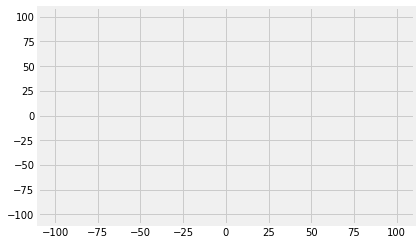

In [17]:
xbnds = np.array([-100.,100.0])
ybnds = np.array([-100,100])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
gridsize= 30;mincnt=0
# Calculate the efficiencies for each location
## Leauge first:
# Normalize the data to one side of the ice
leauge_x_all_shots = leauge_data['Shot']['x'] + leauge_data['Goal']['x'];leauge_y_all_shots = leauge_data['Shot']['y'] + leauge_data['Goal']['y']
leauge_x_all_shots_normalized = [abs(y) for y in leauge_x_all_shots];leauge_y_all_shots_normalized = [-y for y in leauge_y_all_shots]
leauge_x_goal_normalized = [abs(y) for y in leauge_data['Goal']['x']];leauge_y_goal_normalized = [-y for y in leauge_data['Goal']['y']]
leauge_hex_data = plt.hexbin(leauge_x_all_shots_normalized,leauge_y_all_shots_normalized,gridsize=gridsize,extent=extent,mincnt=mincnt,alpha=0.0)
leauge_verts = leauge_hex_data.get_offsets();
leauge_frequency = leauge_hex_data.get_array();
leauge_goal_hex_data = plt.hexbin(leauge_x_goal_normalized,leauge_y_goal_normalized,gridsize=gridsize,extent=extent,mincnt=mincnt,alpha=0.0)
leauge_goal_frequency = leauge_goal_hex_data.get_array();


## Player:
# Normalize the data to one side of the ice
player_x_all_shots = player_data['Shot']['x'] + player_data['Goal']['x'];player_y_all_shots = player_data['Shot']['y'] + player_data['Goal']['y']
player_x_all_shots_normalized = [abs(y) for y in player_x_all_shots];player_y_all_shots_normalized = [-y for y in player_y_all_shots]
player_x_goal_normalized = [abs(y) for y in player_data['Goal']['x']];player_y_goal_normalized = [-y for y in player_data['Goal']['y']]
player_hex_data = plt.hexbin(player_x_all_shots_normalized,player_y_all_shots_normalized,gridsize=gridsize,extent=extent,mincnt=mincnt,alpha=0.0)
player_verts = player_hex_data.get_offsets();
player_frequency = player_hex_data.get_array();
player_goal_hex_data = plt.hexbin(player_x_goal_normalized,player_y_goal_normalized,gridsize=gridsize,extent=extent,mincnt=mincnt,alpha=0.0)
player_goal_frequency = player_goal_hex_data.get_array();


leauge_efficiency = []
player_efficiency = []
relative_efficiency = []
for i in range(0,len(leauge_frequency)):
    if leauge_frequency[i]<2 or player_frequency[i]<2:
        continue
    leauge_efficiency.append(leauge_goal_frequency[i]/leauge_frequency[i])
    player_efficiency.append(player_goal_frequency[i]/player_frequency[i])
    relative_efficiency.append((player_goal_frequency[i]/player_frequency[i])-(leauge_goal_frequency[i]/leauge_frequency[i]))


max_leauge_efficiency = max(leauge_efficiency)
max_player_efficiency = max(player_efficiency)
max_relative_efficiency = max(relative_efficiency)
min_relative_efficiency = min(relative_efficiency)

print("MAX LEAUGE EFFICIENCY: " + str(max_leauge_efficiency))
print("MAX player EFFICIENCY: " + str(max_player_efficiency))
print("max_relative_efficiency: " + str(max_relative_efficiency))
print("min_relative_efficiency: " + str(min_relative_efficiency))

/var/folders/7_/7s8nx4b54jqd_cs1ly0pnpdm0000gn/T/ipykernel_73505/512249373.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = [''], fontsize = 18,alpha = .7,minor=False)
/var/folders/7_/7s8nx4b54jqd_cs1ly0pnpdm0000gn/T/ipykernel_73505/512249373.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = [''], fontsize = 18,alpha = .7,minor=False)


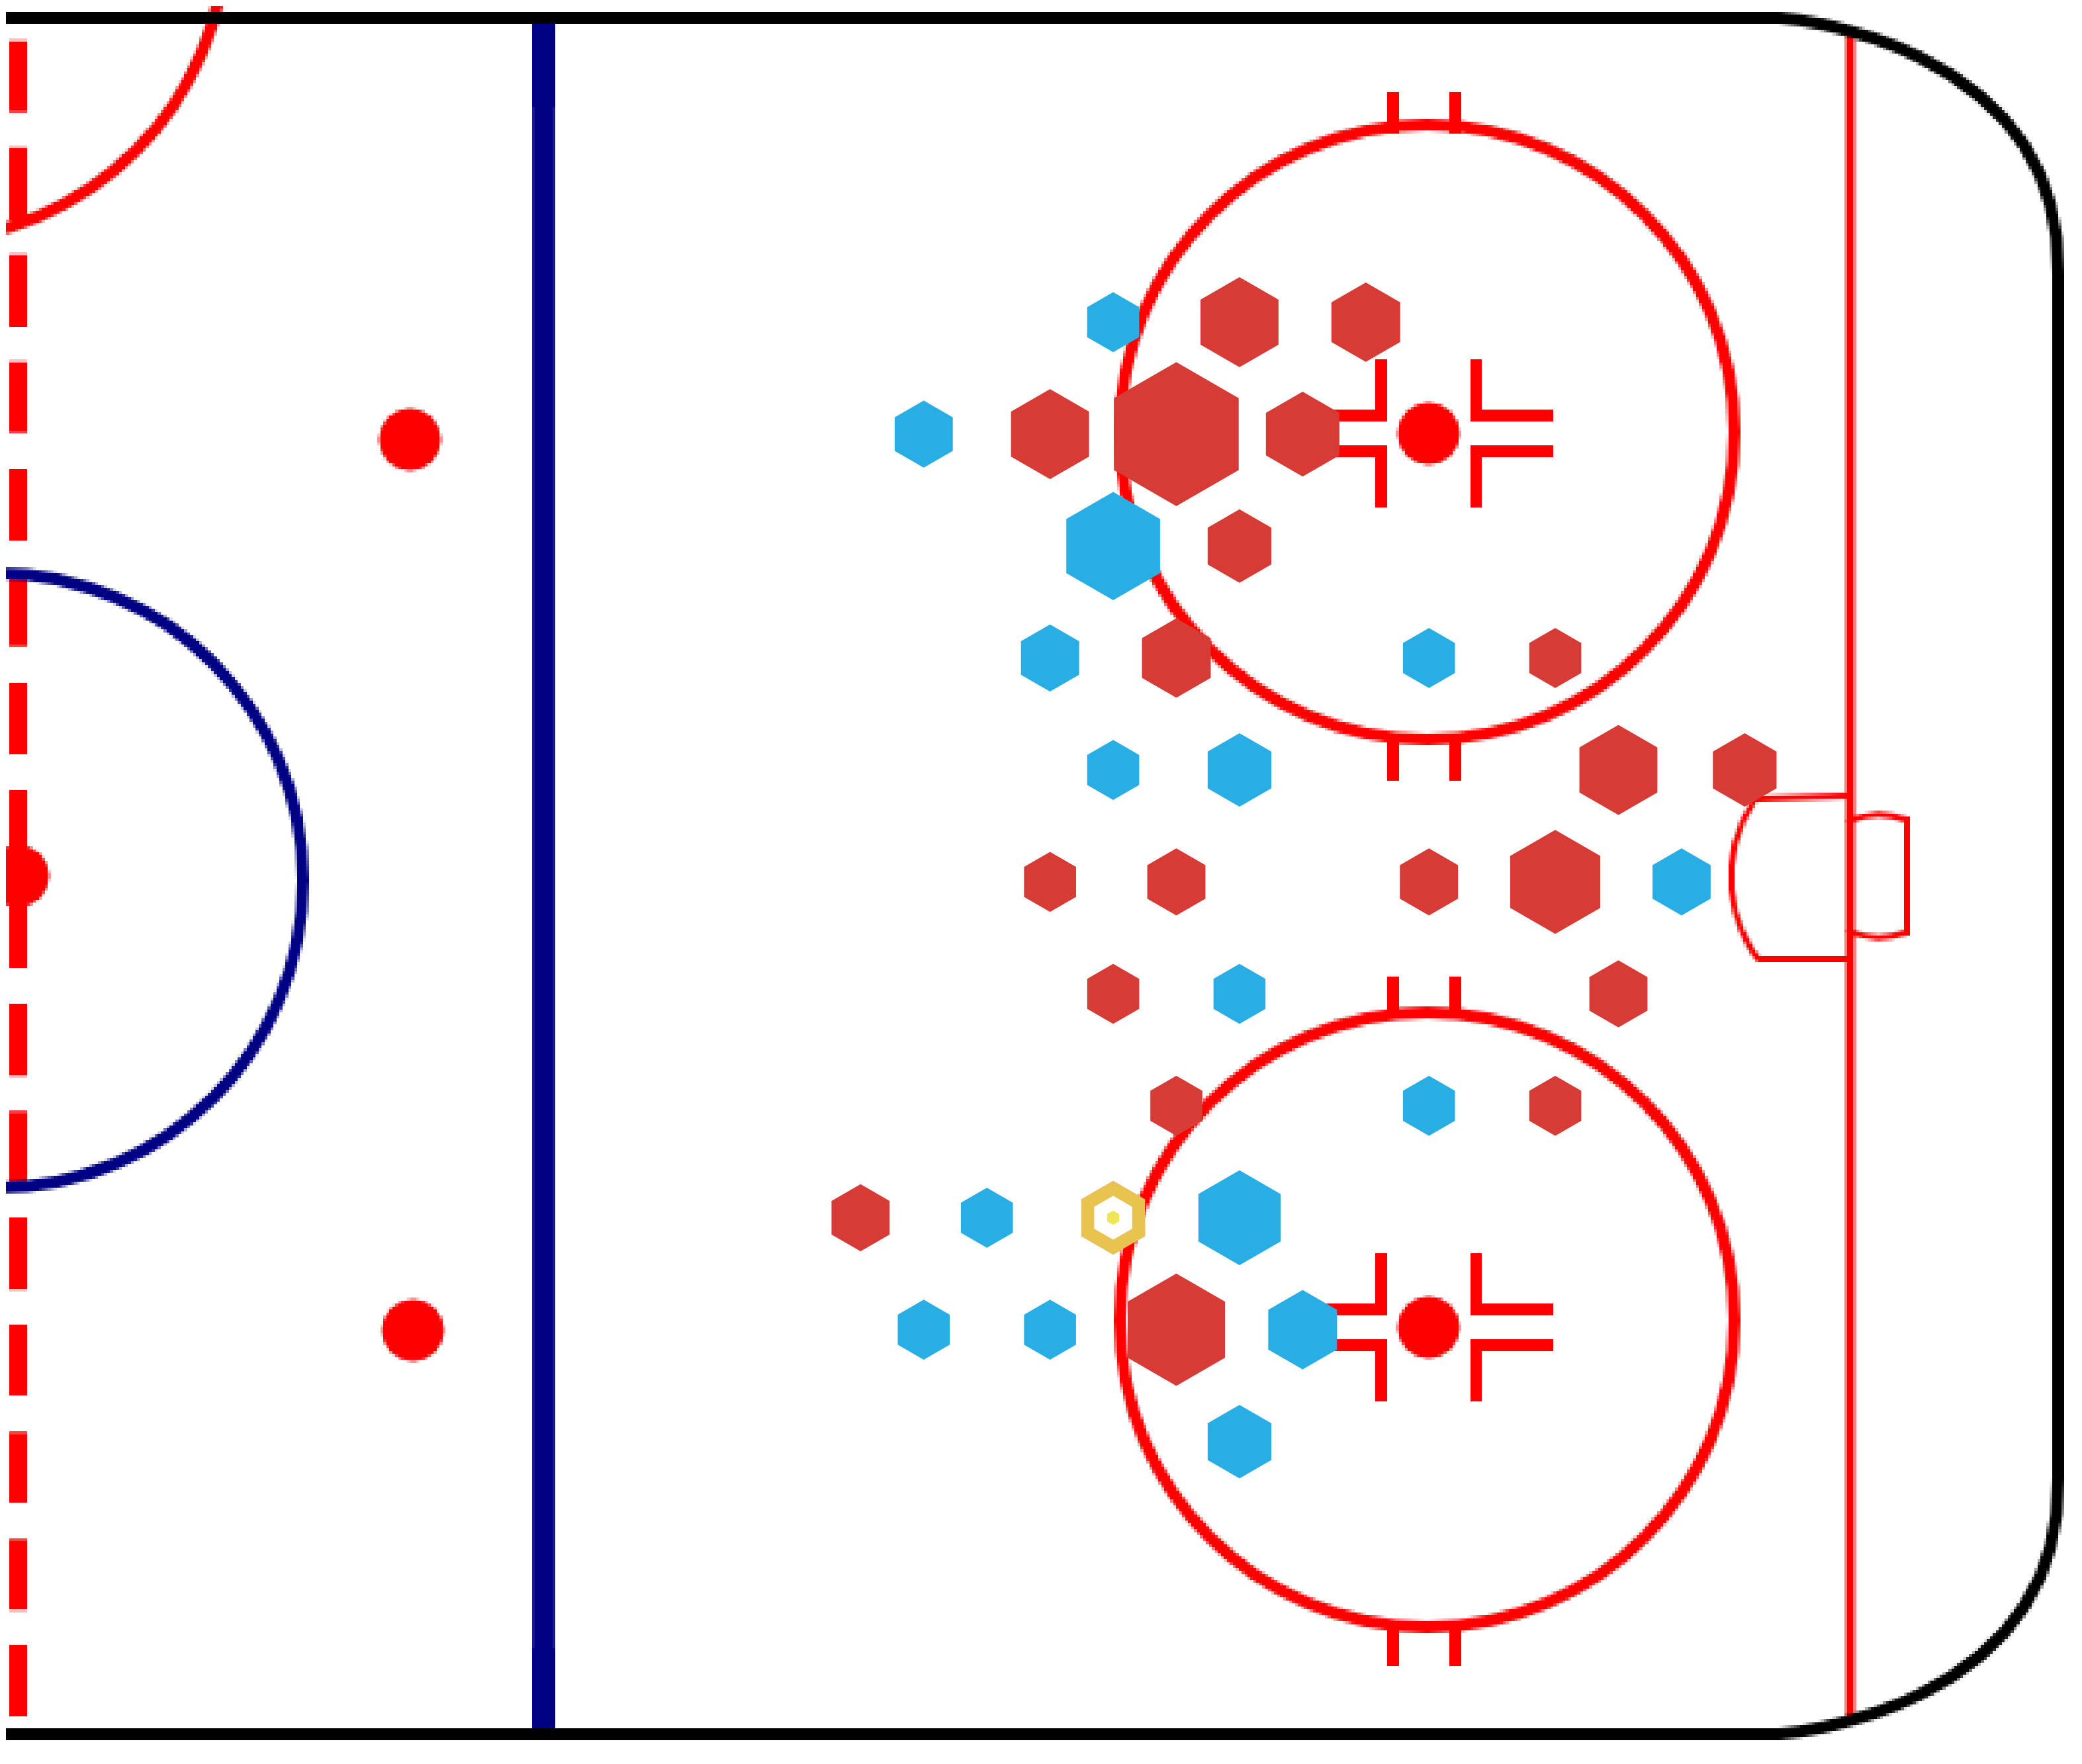

In [19]:
fig=plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)
ax.set_xticklabels(labels = [''], fontsize = 18,alpha = .7,minor=False)
ax.set_yticklabels(labels = [''], fontsize = 18,alpha = .7,minor=False)

I = Image.open('images/half.png')
ax.imshow(I);width, height = I.size
scalingx=width/100-0.6;scalingy=height/100+0.5;x_trans=33;y_trans=height/2
S = 3.8*scalingx;gridsize= 30;mincnt=0
    
best_spot = []
best_spot_r = 0.0
tmp_eff = -1
for i,v in enumerate(player_verts):
    if player_frequency[i] < 4:
        continue
    player_scaled_frequency = player_frequency[i]/max(player_frequency) # Gives the percentage of shots made at that location compared to the max location
    radius = S*math.sqrt(player_scaled_frequency)

    player_efficiency = player_goal_frequency[i]/player_frequency[i]
    leauge_efficiency = leauge_goal_frequency[i]/leauge_frequency[i]
    relative_efficiency = player_efficiency - leauge_efficiency
    relative_efficiency = relative_efficiency
#     print(relative_efficiency)
    if tmp_eff < relative_efficiency:
        tmp_eff=relative_efficiency;
        best_spot = [x_trans+v[0]*scalingx,y_trans+ v[1]*scalingy]
        best_spot_r = radius
    if relative_efficiency>0:
        colour = positive_cm(math.pow(relative_efficiency,0.1))
    else:
        colour = negative_cm(math.pow(-relative_efficiency,0.1))

    hex = RegularPolygon((x_trans+v[0]*scalingx, y_trans+ v[1]*scalingy), \
                         numVertices=6, radius=radius, orientation=np.radians(0), \
                         facecolor=colour, alpha=1.0, edgecolor=None)
    ax.add_patch(hex) 
    
hex = RegularPolygon(best_spot, numVertices=6, radius=best_spot_r, orientation=np.radians(0),facecolor='#eee657', alpha=0.8, edgecolor=None)
ax.add_patch(hex) 
hex = RegularPolygon(best_spot, numVertices=6, radius=best_spot_r-5, orientation=np.radians(0),facecolor='#ffffff', alpha=1, edgecolor=None)
ax.add_patch(hex) 

hex = RegularPolygon(best_spot, numVertices=6, radius=best_spot_r-10, orientation=np.radians(0),facecolor='#eee657', alpha=1, edgecolor=None)
ax.add_patch(hex) 
    
ax.set_xlim([0,width])
ax.set_ylim([0,height])
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.grid(False)

plt.show()